# Идентификация B2B-пользователей веб-сайта электронной коммерции на основе clickstream

## Общая постановка задачи

Когда на сайт заходит посетитель, маркетинг хочет знать, является ли он представителем юридического лица, которое может купить не одну единицу товара, а сразу много. 
Допустим на сайт зашел анонимный посетитель, посерфил страницы и ушел, не оставив своих контактов, и ничего не купив. Нужно запомнить чем интересовался этот посетитель, и если он интересовался B2B-предложениями или фичами, при повторном заходе дать ему специальное предложение в виде всплывающего окна.

Кратко можно записать: **при повторном заходе на сайт, на основе истории кликов из предыдущих сессий, определить заинтересованность пользователя попробовать B2B-предложение и показать offer, если мы считаем что пользователь заинтересован**.

Задачу можно декомпозировать и записать в виде последовательности:
1. посетитель повторно заходит на сайт
2. код фронтенда извлекает из cookies ID посетителя
3. код фронтенда передает ID на бэкенд и запрашивает показывать ли ему специальное предложение
4. на бэкенде с помощью ID посетителя из БД извлекается история предыдущих визитов
5. история визитов передается в алгоритм классификации, который возращает да/нет
6. фронтенд получает ответ показывать ли ему offer
7. по некому триггеру показываем offer или нет

В этом исследовании мы предположим, что пункты 1-4 и 6-7 реализует команда веб-разработчиков. 

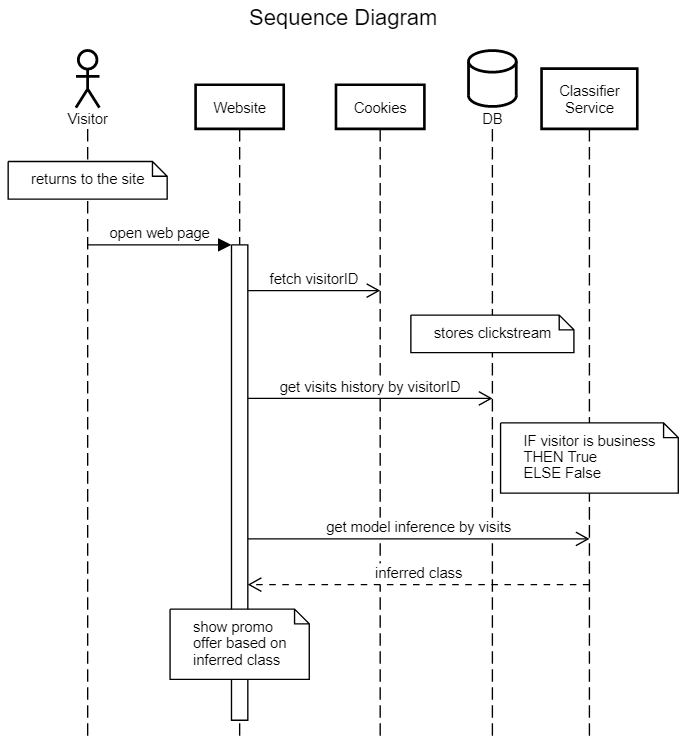

In [5]:
import os
from IPython.display import Image
Image(filename=os.getcwd() + r'\img\seqdiag.png') 

## Содержание ноутбуков

Мы подробно обсудим бизнес-составляющую задачи и пункт 5:

[1. Introduction](1_intro.ipynb)
* определим бизнес-метрики 
* обсудим альтернативное решение 
* формализуем задачу 

[2. Data](2_data.ipynb)
* соберем датасет из Data Warehouse
* определим признаковое пространство, сведем задачу к классификации, определим метки
* почистим и разметим данные, сделаем семплирование

[3. Models](3_models.ipynb)
* историю визитов преобразуем в текст, применим NLP (векторизация, словарь, embeddings)
* сделаем baseline-классфификатор Logistic Regression на "мешке слов"
* обучим градиентный бустинг (XGBoost) на "мешке слов"
* обучим Vanilla RNN на clickstream с помощью PyTorch и построим классфификатор на embeddings

[4. Stats](4_stats.ipynb)
* посчитаем статистическую значимость результатов

## Немного терминологии

*visitor* - посетитель  
*clickstream* - история визитов(кликов)  
*propensity to do smth* - заинтересованность пользователя сделать что-то  
*promo offer, offer, treatment, incentive* - специальное предложение

## Бизнес-метрики и A/B тестирование

### Бизнес метрики

Все бизнес-метрики предприятия электронной коммерции так или иначе можно свести к прибыли, так как это основная цель такого рода компаний. Мы выберем ближайшую специфическую для задачи метрику, которая положительно коррелирует с прибылью.

Для этого введем дополнительные условия. Бизнес-страницы сайта побуждают посетителя оставить свои контактные данные, в первую очередь бизнес-email. На страницах в разных местах размещены CTA(call to action), с переходом на форму регистрации.

В нашем случае мы добавляем дополнительный стимул оставить свои данные. Это попап окно со специальным предложением, которое ведет на ту же самую форму регистрации.
Для того, чтобы воспользоваться предложением, бизнес-посетитель должен будет создать бизнес-аккаунт.

Таким образом мы можем ввести метрику Number of Business Accounts Created:

$$NBA = count(a),$$  где $a$ - множество созданных бизнес-аккаунтов.

Обычно метрики такого рода считаются на интервалах времени, т.е. *per week, month, quarter, year*.

Логично предположить, что нам следует увеличивать количество регистрируемых бизнес-аккаунтов.

### A/B тестирование и статистическая значимость

Для того, чтобы оценить влияние решения на оптимизируемую метрику, на практике проводят так называемые A/B-тесты или эксперименты.

Сначала нужно отобрать экспериментальные группы пользователей. Например, одна из них будет получать offer, другая не будет. После чего нужно посчитать метрику(и) на обеих группах, статистическую значимость различий значений метрики и сделать вывод о пользе предложения.

К выбору групп пользователей для эксперимента нужно подходить максимально обдуманно, чтобы получились несмещенные оценки. В нашем случае, если это возможно, лучше поделить траффик случайным образом на 2 части и одновременно запустить оба подхода.
Если невозможно, то нужно учесть множество факторов, чтобы отобрать именно те две группы, которые позволят получить несмещенные оценки. Примерами таких факторов могут быть: сезонность, день недели, выходной или рабочий дни, страна, возраст, пол и т.д.

Проведение A/B теста не является целью этой работы, поэтому далее рассматривать эту тему мы не будем.

## Альтернативное решение

Так как эта задача взята из реальной жизни, то было бы неверно предполагать, что её не пытались решить без использования Machine Learning.

Было предложено показывать offer всем посетителям, которые ранее заходили на специфические B2B страницы. Решение звучит на мой взгляд разумно.
Его основной проблемой является то, что список этих страниц нужно постоянно обновлять вручную. Для этого нужно как минимум два человека: один от бизнеса, следящий за своевременностью обновления списка и разработчик, который должен будет внедрять эти измения в код сайта. На практике в этой схеме может быть множество других ролей, как со стороны бизнеса, так и разработки.
Количество точек отказа растет с каждым новым участником процесса.

Автоматизации такое решение плохо поддаётся, всегда нужно знать какие ранее посещенные страницы приведут к срабатыванию триггера. Страницы и их адреса меняются, маркетологи регулярно пробуют что-то новое.

Желательно чтобы список страниц формировался автоматически. Задачу можно решить с помощью классификатора, который во время обучения будет находить искомые признаки-страницы и использовать их для нужного нам вывода. Посмотрим как это можно сделать.

## Формальная постановка задачи

Нам дано:

$P = \{p_1, \dotsc, p_n\}$ $\forall p_i \in \mathbb{N}$ - множество страниц сайта, представленное индексами в словаре.

$A = \{r, b\}$ - множество типов аккаунтов, которые посетитель может создать (regular и business).
 
Определим пространство признаков $X = (x_1, \dotsc, x_n)$, где $\forall x_i \in P$ и пространство ответов ${Y} = (0, 1)$ на множестве $A$, где $0 = r$ - обычный посетитель, $1 = b$ - бизнес посетитель.

$x = (x^1, x^2, \dotsc, x^d)$ - признаковое описание объекта, т.е. clickstream.  
$y$ - ответ на объекте.  
$X = (x_i, y_i)^l_{i=1}$ - обучающая выборка.

Найти нужно алгоритм классификатора $a(X)$, т.е. решить задачу обучения с учителем.